In [58]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

## VGG-16

The VGG16 model proposed was tested using the ImageNet data set, which contains over 15 million hand labeled high-resolution images, that belong to around 22-thousand categories. The model was trained for weeks, and pre-trained models are commonly available using deep learning APIs.

In [12]:
vgg16_pretrained = VGG16(include_top=False, weights='imagenet', input_shape=(768,1024,3))
vgg16_pretrained.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 768, 1024, 3)]    0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 768, 1024, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 768, 1024, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 384, 512, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 384, 512, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 384, 512, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 192, 256, 128)     0     

In [51]:
vgg16_pretrained.layers[0]

## The U-Net architecture
U-Net was originally published as a convolutional network for biomedical image segmentation.
The UNet architecture consists of two paths, which are commonly reffered to in deep learning as the encoder- and
decoder networks. UNet's encoder captures the context of input images, and it contains a symmetric decoder that allows to localization using a technique called upsampling (fractional convolution or transposed convolution.) 
<br><br>
![Unet](resources/UNet.PNG)


### VGG16-U-Net
The idea is to use the pre-trained VGG16 model as the encoder to a U-Net model, and also to construct a symmetric decoder network.

In [61]:
class VGGUnet(object):
    
    def __init__(self, segmentation_shape=(768, 1024, 3)):
        self.segmentation_shape = segmentation_shape
        self.model = self._build_model(self.segmentation_shape)
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    def _build_model(self, segmentation_shape):
        encoder = VGG16(include_top=False, weights='imagenet', input_shape=segmentation_shape)
        
        # Decoder block1, from Encoder output
        encoder_output = encoder.output
        conv_0 = Conv2D(512, (3, 3), activation='relu', padding='same')(encoder_output)
        conv_0_up = Conv2DTranspose(256, (3, 3), strides=(2,2), activation='relu', padding='same')(conv_0)
        
        # Decoder block 1, concat block with encoder block 5
        concat_1 = concatenate([encoder.get_layer('block5_conv3').output, conv_0_up])
        conv_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat_1)
        conv_1_up =  Conv2DTranspose(256, (3, 3), strides=(2,2), activation='relu', padding='same')(conv_1)
        
        # Decoder block 2, concat block with encoder block 4
        concat_2 = concatenate([encoder.get_layer('block4_conv3').output, conv_1_up])
        conv_2 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat_2)
        conv_2_up =  Conv2DTranspose(256, (3, 3), strides=(2,2), activation='relu', padding='same')(conv_2)
        
        # Decoder block 3, concat block with encoder block 3
        concat_3 = concatenate([encoder.get_layer('block3_conv3').output, conv_2_up])
        conv_3 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat_3)
        conv_3_up =  Conv2DTranspose(128, (3, 3), strides=(2,2), activation='relu', padding='same')(conv_3)
        
        # Decoder block 4, concat block with encoder block 2
        concat_4 = concatenate([encoder.get_layer('block2_conv2').output, conv_3_up])
        conv_4 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_4)
        conv_4_up =  Conv2DTranspose(64, (3, 3), strides=(2,2), activation='relu', padding='same')(conv_4)
        
        # Decoder block 5, concat block with encoder block 1
        concat_5 = concatenate([encoder.get_layer('block1_conv2').output, conv_4_up])
        conv_5 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_5)
        
        return Model(inputs=[encoder.layers[0].input], outputs=[conv_5])

In [62]:
vgg_unet = VGGUnet()

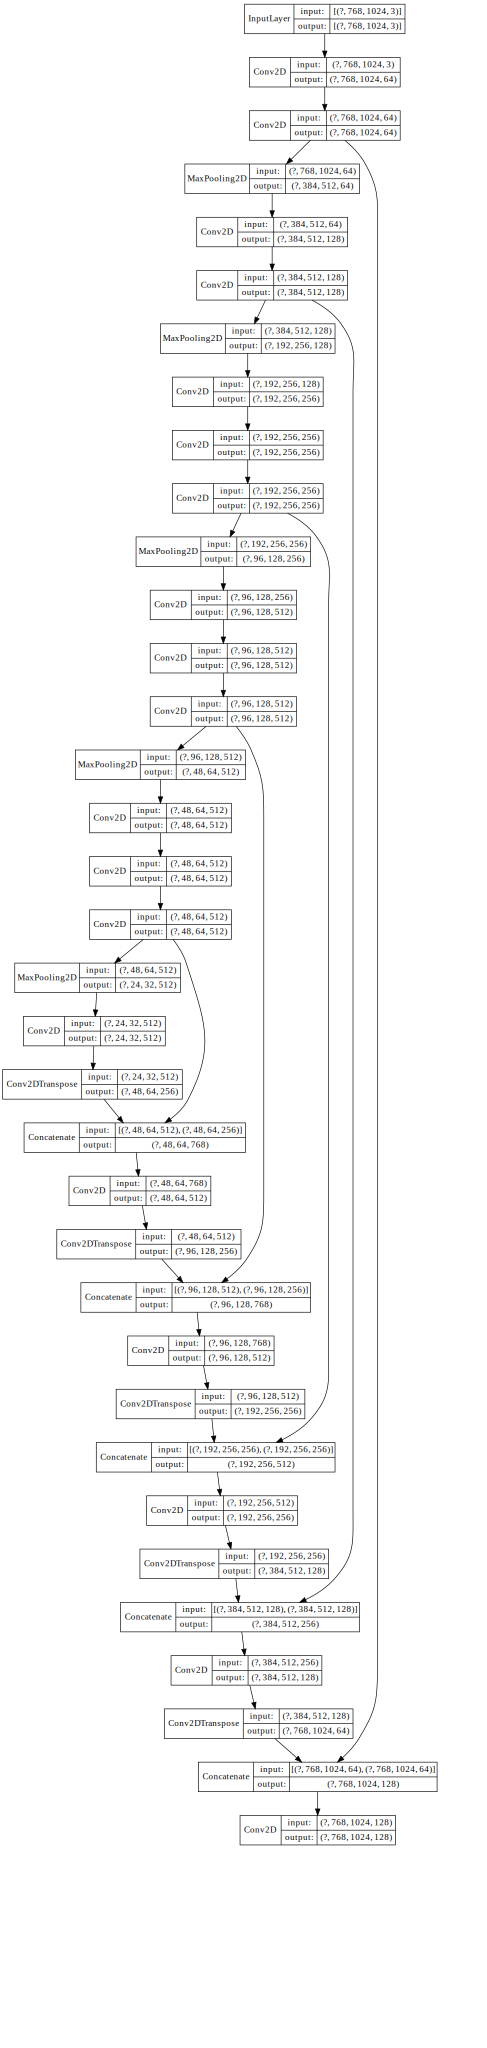

In [64]:
SVG(model_to_dot(vgg_unet.model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB', dpi=65).create(prog='dot', format='svg'))